In [5]:
import rasterio
import fiona
import numpy as np
import rasterio.features
from matplotlib import pyplot as plt
%matplotlib inline  

In [1]:
def save_bitmap(file_path, image, source):
    """Save a bitmap given as a 2D matrix as a GeoTIFF."""

    print("Save result at {}.".format(file_path))
    with rasterio.open(
            file_path,
            'w',
            driver='GTiff',
            dtype=rasterio.uint8,
            count=1,
            width=source.width,
            height=source.height,
            transform=source.transform) as dst:
        dst.write(image, indexes=1)

def create_bitmap(raster_dataset, shapefile_paths):
    """Create the bitmap for a given satellite image."""

    water_features = np.empty((0, ))

    print("Create bitmap for water features.")
    for shapefile_path in shapefile_paths:
        try:
            print("Load shapefile {}.".format(shapefile_path))
            with fiona.open(shapefile_path) as shapefile:
                # Each feature in the shapefile also contains meta information such as
                # wether the features is a lake or a river. We only care about the geometry
                # of the feature i.e. where it is located and what shape it has.
                geometries = [feature['geometry'] for feature in shapefile if feature["geometry"] is not None]

                water_features = np.concatenate(
                    (water_features, geometries), axis=0)
        except IOError as e:
            print("No shapefile found.")
            sys.exit(1)

    # Now that we have the vector data of all water features in our satellite image
    # we "burn it" into a new raster so that we get a B/W image with water features
    # in white and the rest in black. We choose the value 255 so that there is a stark
    # contrast between water and non-water pixels. This is only for visualisation
    # purposes. For the classifier we use 0s and 1s.
    bitmap_image = rasterio.features.rasterize(
        ((g, 255) for g in water_features),
        out_shape=raster_dataset.shape,
        transform=raster_dataset.transform)

    save_bitmap(tif_path, bitmap_image, raster_dataset)

    bitmap_image[bitmap_image == 255] = 1
    return bitmap_image


In [7]:
tif_path  = 'tif_tests/bitmap_pilar_sub.tif'
raster_test = "clip_sub_S2A_OPER_MSI_L1C_TL_MTI__20160330T201750_A004025_T21HUB_B0stack_raster.tif"
raster_dataset = rasterio.open(raster_test)
shapefile_paths = ["./techo_2016/techo_2016_21s/techo_2016_21s.shp"]
img = create_bitmap(raster_dataset, shapefile_paths)

Create bitmap for water features.
Load shapefile ./techo_2016/techo_2016_21s/techo_2016_21s.shp.
Save result at tif_tests/bitmap_pilar_sub.tif.


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:47: FutureWarning: The value of this property will change in version 1.0. Please see https://github.com/mapbox/rasterio/issues/86 for details.


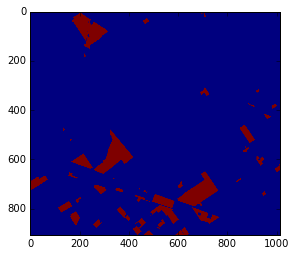

In [12]:
plt.figure()
plt.imshow(img)
plt.show()